### AIM: To predict the probability of an online lead getting converted to sales.

### Steps:

1. Data Analysis
2. Feature Engineering
3. Feature Selection
4. Model Building
5. Model Evaluation

#### Import libraries

In [1]:
import pyforest

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

sns.set()

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<IPython.core.display.Javascript object>

#### Read Input Data

In [2]:
path = r'./data.xlsx'

# reading the data in dataframe
df = pd.read_excel(path)

df.head()

<IPython.core.display.Javascript object>

,id,Gender,Age,Area code,Have hearing aid,Hearing aid age,Have ENT prescription,Distance to store (in km),Sales
0,167647,Male,48,7.0,0.0,< 1 Year,No,25.0,0
1,17163,Male,32,28.0,0.0,1-2 Year,Yes,32.0,0
2,32023,Female,43,33.0,0.0,1-2 Year,Yes,26.0,0
3,87447,Female,37,33.0,0.0,< 1 Year,No,20.0,0
4,501933,Male,43,46.0,0.0,< 1 Year,No,44.0,0


In [3]:
df.shape

(357970, 9)

In [4]:
df.describe()

,id,Age,Area code,Have hearing aid,Distance to store (in km),Sales
count,357970.000000,357970.000000,357947.000000,357465.000000,357945.000000,357970.000000
mean,230874.387809,41.178079,26.381671,0.553386,35.007842,0.027041
std,137869.896274,8.340704,13.290270,0.497142,6.054417,0.162204
min,3.000000,30.000000,0.000000,0.000000,20.000000,0.000000
25%,113167.250000,35.000000,15.000000,0.000000,30.000000,0.000000
50%,226595.500000,41.000000,28.000000,1.000000,35.000000,0.000000
75%,339778.500000,46.000000,35.000000,1.000000,40.000000,0.000000
max,508145.000000,85.000000,52.000000,1.000000,45.000000,1.000000


### Exploratory Data Analysis

In Data Analysis We will analyze to find out:

1. Missing Values
2. All The Numerical Variables
3. Distribution of the Numerical Variables
4. Categorical Variables
5. Cardinality of Categorical Variables
6. Outliers Detection

#### 1. Check missing values

In [5]:
# Features with total missing values > 1
missing_features = [f for f in df.columns if df[f].isnull().sum() > 1]

# Displaying features with missing values and % missing records
for f in missing_features:
    print(f,' --->', round(df[f].isnull().mean(),4), ' % missing values')

Area code  ---> 0.0001  % missing values
Have hearing aid  ---> 0.0014  % missing values
Hearing aid age  ---> 0.0019  % missing values
Distance to store (in km)  ---> 0.0001  % missing values


##### In the above dataset features like id is not required, So we will drop them in Feature Engineering.

#### 2. Numerical Features

In [6]:
# list of numerical features
numerical_features = [f for f in df.columns if df[f].dtypes != 'O']
df[numerical_features].head()

,id,Age,Area code,Have hearing aid,Distance to store (in km),Sales
0,167647,48,7.0,0.0,25.0,0
1,17163,32,28.0,0.0,32.0,0
2,32023,43,33.0,0.0,26.0,0
3,87447,37,33.0,0.0,20.0,0
4,501933,43,46.0,0.0,44.0,0


<IPython.core.display.Javascript object>

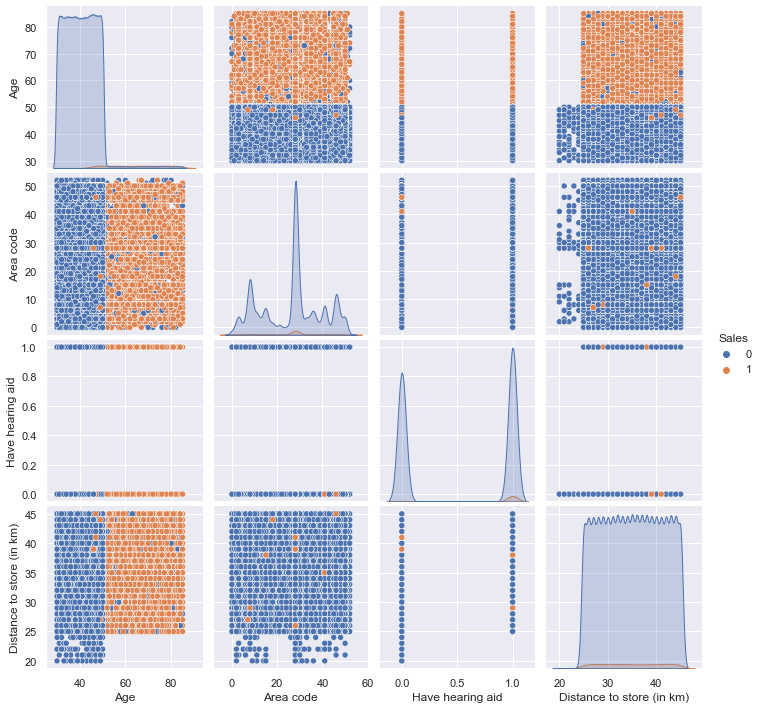

In [7]:
# Relation among numerical features based on Sales
pairplot_features = [f for f in df.columns if df[f].dtypes != 'O' and f not in ['id']]
sns.pairplot(df[pairplot_features], hue = 'Sales')

##### Since there are lots of overlap among features, we can't use linearly separable algorithms (like LogReg)

#### Numerical variables are usually of 2 type
1. Continous variable
2. Discrete Variables

#### Discrete features conditions:
1. should not be id column
2. should be one of the numerical features having unique values < 25 (say)

Since continous numerical can have any number as it's value.

In [8]:
# Discrete numerical features with unique values <25 (say)
discrete_features = [f for f in numerical_features if len(df[f].unique()) < 25 and f not in ['id']]
print("Discrete Variables Count: {}".format(len(discrete_features)))

df[discrete_features].head()

Discrete Variables Count: 2


,Have hearing aid,Sales
0,0.0,0
1,0.0,0
2,0.0,0
3,0.0,0
4,0.0,0


#### Continuous Variable

Condition:

1. should not be id column
2. should not be in discrete variables
3. should be one of the numerical features

In [9]:
# Continous numerical features with any value
continous_features = [f for f in numerical_features if f not in discrete_features + ['id']]
print("Continuous feature Count {}".format(len(continous_features)))

df[continous_features].head()

Continuous feature Count 3


,Age,Area code,Distance to store (in km)
0,48,7.0,25.0
1,32,28.0,32.0
2,43,33.0,26.0
3,37,33.0,20.0
4,43,46.0,44.0


#### Let's see the distribution of these continous numerical features

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

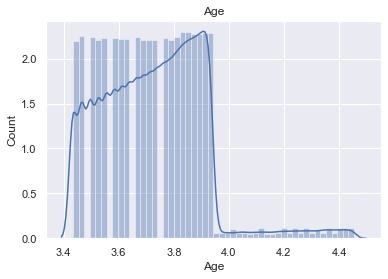

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

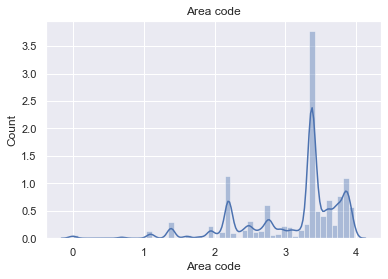

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

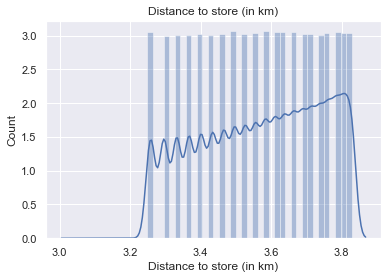

In [10]:
# Lets analyse the continuous values by creating histograms to understand the distribution.
for feature in continous_features:
    data = df.copy()
    ax = sns.distplot(np.log1p(data[feature]))
    
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

##### It is clearly visible from the above plots, most of the features do not follow a normal distribution.

#### Outliers Detection

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

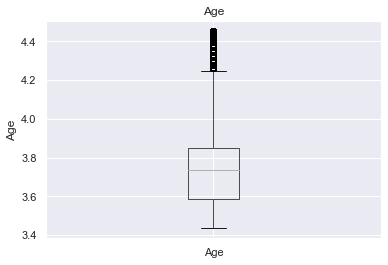

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

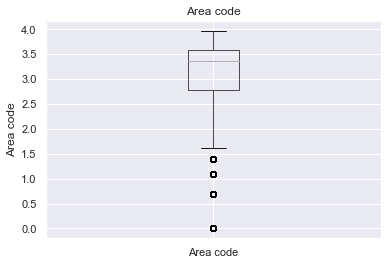

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

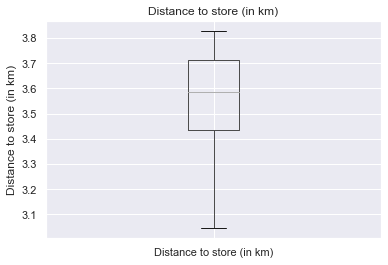

In [11]:
# Box Plot to anlayse the outliers
for feature in continous_features:
    data=df.copy()
    data[feature]=np.log1p(data[feature])
    data.boxplot(column=feature)
    
    plt.ylabel(feature)
    plt.title(feature)
    plt.show()

#### There are outliers present in features like Age and Area Code.

#### Analysing Categorical Variables

In [12]:
# List of categorical features
categorical_features = [feature for feature in df.columns if data[feature].dtypes == 'O']
print('Length of categorical features', len(categorical_features))

df[categorical_features].head()

Length of categorical features 3


,Gender,Hearing aid age,Have ENT prescription
0,Male,< 1 Year,No
1,Male,1-2 Year,Yes
2,Female,1-2 Year,Yes
3,Female,< 1 Year,No
4,Male,< 1 Year,No


#### Cardinality of the Categorical Features

In [13]:
for feature in categorical_features:
    print('The feature is {} and unique values are {}'.
          format(feature,len(data[feature].unique())))

The feature is Gender and unique values are 2
The feature is Hearing aid age and unique values are 6
The feature is Have ENT prescription and unique values are 2


#### Features have < 6 unique values, they can easily be handled with One Hot Encoding.

### Segregating the independent and dependent variable

In [14]:
X = df.drop(['Sales'], axis = 1)
y = df['Sales']

print(X.shape, y.shape)

(357970, 8) (357970,)


#### Splitting the dataset into training and testing dataset

In [15]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=1)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(286376, 8) (286376,)
(71594, 8) (71594,)


### Feature Engineering
We will be performing all the below steps in Feature Engineering

1. Handling missing values
2. Categorical variables: remove rare labels
3. Standarise the values of the variables to the same range
4. Convert Categorical into Numerical

#### Handling Categorical Missing Values

In [16]:
# Categorical missing features
cat_missing_features = [f for f in df.columns if df[f].dtypes == 'O' and df[f].isnull().sum() >1]
for f in cat_missing_features:
    print('{}: {} % missing values'.format(f, np.round(df[f].isnull().mean(),4)))

<IPython.core.display.Javascript object>

Hearing aid age: 0.0019 % missing values


In [17]:
# Imputation of missing categorical features and replacing missing values with a new label
def replace_cat_feature(df,f):
    data = df.copy()
    data[f]=data[f].fillna('Missing')
    return data

In [18]:
X_train = replace_cat_feature(X_train, cat_missing_features)
X_test = replace_cat_feature(X_test, cat_missing_features)

#### Handling Numerical Missing Values

In [19]:
num_missing_features = [f for f in df.columns if df[f].isnull().sum() > 1 and df[f].dtypes!='O']
num_missing_features

['Area code', 'Have hearing aid', 'Distance to store (in km)']

In [20]:
def replace_numerical_missing(df, num_missing_features):
    ## Replacing the numerical Missing Values
    for f in num_missing_features:
        ## We will replace by using median since there are outliers.
        median_value = df[f].median()

        # Replace missing values in original column by median 
        df[f].fillna(median_value,inplace=True)

    return df

In [21]:
X_train = replace_numerical_missing(X_train, num_missing_features)
X_test = replace_numerical_missing(X_test, num_missing_features)

In [22]:
print('Missing values in train data after imputation\n', X_train[num_missing_features].isnull().sum())
print('\nMissing values in test data after imputation\n', X_test[num_missing_features].isnull().sum())

Missing values in train data after imputation
 Area code                    0
Have hearing aid             0
Distance to store (in km)    0
dtype: int64

Missing values in test data after imputation
 Area code                    0
Have hearing aid             0
Distance to store (in km)    0
dtype: int64


#### Handling Rare Categorical Feature

In [23]:
categorical_features=[feature for feature in df.columns if df[feature].dtype=='O']
categorical_features

['Gender', 'Hearing aid age', 'Have ENT prescription']

In [24]:
def replace_rare_category(X,y, categorical_features):
    df = pd.concat([X,y], axis=1)
    
    for f in categorical_features:
        # Calculate the percentage of every category value
        perc = df.groupby(f)['Sales'].count()/len(df)
        print('\nPercentage of categories: ',perc)

        # Keep index of all those whose perc > 0.01
        temp = perc[perc > 0.01].index

        # Replacing records with a new category 'Rare_Var' where less than 1%
        df[f] = np.where(df[f].isin(temp), df[f], 'Rare_Var')

        print('New unique values: ', df[f].unique())
        
    return df.drop('Sales', axis = 1)

In [25]:
X_train = replace_rare_category(X_train, y_train, categorical_features)

print('\nTrain data: ', X_train[categorical_features].head())

<IPython.core.display.Javascript object>


Percentage of categories:  Gender
Female    0.467993
Male      0.532007
Name: Sales, dtype: float64


<IPython.core.display.Javascript object>

New unique values:  ['Male' 'Female']

Percentage of categories:  Hearing aid age
1-2 Year     0.478602
4-5 years    0.005213
5 years      0.028417
< 1 Year     0.452409
> 2 Years    0.033456
Missing      0.001903
Name: Sales, dtype: float64


<IPython.core.display.Javascript object>

New unique values:  ['< 1 Year' '1-2 Year' '> 2 Years' '5 years' 'Rare_Var']

Percentage of categories:  Have ENT prescription
No     0.615107
Yes    0.384893
Name: Sales, dtype: float64


<IPython.core.display.Javascript object>

New unique values:  ['No' 'Yes']

Train data:         Gender Hearing aid age Have ENT prescription
234871   Male        < 1 Year                    No
133648   Male        1-2 Year                    No
18656    Male        1-2 Year                    No
183853   Male        1-2 Year                    No
86972    Male        1-2 Year                    No


In [26]:
X_test = replace_rare_category(X_test, y_test, categorical_features)

print('Test data: ', X_test[categorical_features].head())

<IPython.core.display.Javascript object>


Percentage of categories:  Gender
Female    0.464117
Male      0.535883
Name: Sales, dtype: float64


<IPython.core.display.Javascript object>

New unique values:  ['Female' 'Male']

Percentage of categories:  Hearing aid age
1-2 Year     0.479495
4-5 years    0.005503
5 years      0.027055
< 1 Year     0.452650
> 2 Years    0.033229
Missing      0.002067
Name: Sales, dtype: float64


<IPython.core.display.Javascript object>

New unique values:  ['1-2 Year' '< 1 Year' '> 2 Years' '5 years' 'Rare_Var']

Percentage of categories:  Have ENT prescription
No     0.614227
Yes    0.385773
Name: Sales, dtype: float64


<IPython.core.display.Javascript object>

New unique values:  ['Yes' 'No']
Test data:          Gender Hearing aid age Have ENT prescription
355072  Female        1-2 Year                   Yes
247720    Male        1-2 Year                    No
299957  Female        < 1 Year                   Yes
32885     Male        1-2 Year                    No
321089    Male        1-2 Year                   Yes


### Feature Scaling

##### Before doing feature scaling,we need to convert the categorical values into numerical features.

In [27]:
def scale_features(X,y, categorical_features):
    df = pd.concat([X,y], axis = 1)
    
    for feature in categorical_features:
        labels_ordered = df.groupby([feature])['Sales'].mean().sort_values().index
        print('Initial: ',labels_ordered)

        labels_ordered={k:i for i,k in enumerate(labels_ordered,0)}
        print('\nLater:', labels_ordered)

        df[feature]=df[feature].map(labels_ordered)
        print('\n')
        
    return df.drop('Sales', axis = 1)

In [28]:
X_train = scale_features(X_train, y_train, categorical_features)

print('\nTrain data: ', X_train[categorical_features].head())

<IPython.core.display.Javascript object>

Initial:  Index(['Female', 'Male'], dtype='object', name='Gender')

Later: {'Female': 0, 'Male': 1}


Initial:  Index(['< 1 Year', '1-2 Year', '> 2 Years', 'Rare_Var', '5 years'], dtype='object', name='Hearing aid age')

Later: {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2, 'Rare_Var': 3, '5 years': 4}


Initial:  Index(['No', 'Yes'], dtype='object', name='Have ENT prescription')

Later: {'No': 0, 'Yes': 1}



Train data:          Gender  Hearing aid age  Have ENT prescription
234871       1                0                      0
133648       1                1                      0
18656        1                1                      0
183853       1                1                      0
86972        1                1                      0


In [29]:
X_test = scale_features(X_test, y_test, categorical_features)

print('\nTest data: ', X_test[categorical_features].head())

<IPython.core.display.Javascript object>

Initial:  Index(['Female', 'Male'], dtype='object', name='Gender')

Later: {'Female': 0, 'Male': 1}


Initial:  Index(['< 1 Year', '1-2 Year', '> 2 Years', 'Rare_Var', '5 years'], dtype='object', name='Hearing aid age')

Later: {'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2, 'Rare_Var': 3, '5 years': 4}


Initial:  Index(['No', 'Yes'], dtype='object', name='Have ENT prescription')

Later: {'No': 0, 'Yes': 1}



Test data:          Gender  Hearing aid age  Have ENT prescription
355072       0                1                      1
247720       1                1                      0
299957       0                0                      1
32885        1                1                      0
321089       1                1                      1


### Min Max Standardization

In [30]:
features_to_scale = [f for f in X_train.columns if f not in ['id']]
features_to_scale

['Gender',
 'Age',
 'Area code',
 'Have hearing aid',
 'Hearing aid age',
 'Have ENT prescription',
 'Distance to store (in km)']

In [31]:
def min_max_scale(df,scaler, features_to_scale):   
    scaler.fit(df[features_to_scale])
    
    # transform the train and test set, and add on the Id variables
    data = pd.concat([df[['id']].reset_index(drop=True), 
                      pd.DataFrame(scaler.transform(df[features_to_scale]), 
                                   columns = features_to_scale)],
                     axis=1)
    return df

In [32]:
scaler = MinMaxScaler()

In [33]:
# transform the train and test set, and add on the id variables
X_train = min_max_scale(X_train, scaler, features_to_scale)
X_train.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,id,Gender,Age,Area code,Have hearing aid,Hearing aid age,Have ENT prescription,Distance to store (in km)
234871,209921,1,35,30.0,1.0,0,0,35.0
133648,484334,1,31,3.0,0.0,1,0,32.0
18656,391725,1,43,3.0,0.0,1,0,43.0
183853,360111,1,30,28.0,0.0,1,0,37.0
86972,350384,1,31,46.0,1.0,1,0,39.0


In [34]:
X_test = min_max_scale(X_test, scaler, features_to_scale)
X_test.head()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

,id,Gender,Age,Area code,Have hearing aid,Hearing aid age,Have ENT prescription,Distance to store (in km)
355072,361310,0,34,28.0,0.0,1,1,33.0
247720,181501,1,39,47.0,0.0,1,0,30.0
299957,59186,0,40,26.0,0.0,0,1,36.0
32885,456723,1,50,15.0,0.0,1,0,37.0
321089,86836,1,30,47.0,0.0,1,1,42.0


In [35]:
X_train.to_csv('X_train.csv',index=False)
X_test.to_csv('X_test.csv',index=False)

### Feature Selection

We will use combination of Lasso and SelectFromModel libraries from sklearn to select the best features.

In [36]:
# select k best features from training dataset
feature_sel_model = SelectFromModel(Lasso(alpha=0.005, random_state=0)) # remember to set the seed, the random state in this function
feature_sel_model.fit(X_train, y_train)

SelectFromModel(estimator=Lasso(alpha=0.005, random_state=0))

In [37]:
# False: Not important & True: Important
feature_sel_model.get_support()

array([False, False,  True,  True,  True,  True, False, False])

In [38]:
# Let's see the total and the selected features
selected_features = X_train.columns[(feature_sel_model.get_support())]

print('Total features are {}'.format(X_train.shape[1]))
print('Selected features are {}'. format(len(selected_features)))
print('Features with coeff 0 are {}'.format(np.sum(feature_sel_model.estimator_.coef_ == 0))) # Skipped features, coeff becomes 0 by Lasso.

Total features are 8
Selected features are 4


<IPython.core.display.Javascript object>

Features with coeff 0 are 3


In [39]:
# selected features
print(selected_features)

Index(['Age', 'Area code', 'Have hearing aid', 'Hearing aid age'], dtype='object')


In [40]:
X_train = X_train[selected_features]
X_train.head()

,Age,Area code,Have hearing aid,Hearing aid age
234871,35,30.0,1.0,0
133648,31,3.0,0.0,1
18656,43,3.0,0.0,1
183853,30,28.0,0.0,1
86972,31,46.0,1.0,1


In [41]:
X_test = X_test[selected_features]
X_test.head()

,Age,Area code,Have hearing aid,Hearing aid age
355072,34,28.0,0.0,1
247720,39,47.0,0.0,1
299957,40,26.0,0.0,0
32885,50,15.0,0.0,1
321089,30,47.0,0.0,1


### Handle imbalanced dataset

<AxesSubplot:>

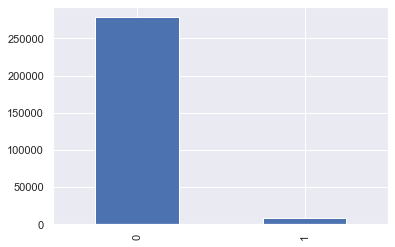

In [42]:
# plotting the value counts of Sales
y_train.value_counts().plot(kind = 'bar')

#### RandomOverSampler

In [43]:
# Oversample by 75%.
os = RandomOverSampler(0.75)

# New balanced X_train and y_train
X_train_bal_os, y_train_bal_os = os.fit_resample(X_train, y_train)

print('The number of classes before fit: {}'.format(y_train.value_counts()))
print('\nThe number of classes after fit: {}'.format(y_train_bal_os.value_counts()))

The number of classes before fit: 0    278597
1      7779
Name: Sales, dtype: int64

The number of classes after fit: 0    278597
1    208947
Name: Sales, dtype: int64


#### SMOTETOMEK OverSampler

In [44]:
# Oversample by 75%
smt = SMOTETomek(0.75)

# New balanced X_train and y_train
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

print('The number of classes before fit: {}'.format(y_train.value_counts()))
print('\nThe number of classes after fit: {}'.format(y_train_smt.value_counts()))

The number of classes before fit: 0    278597
1      7779
Name: Sales, dtype: int64

The number of classes after fit: 0    278571
1    208921
Name: Sales, dtype: int64


### Model Building: Random Forest

#### After RandomOverSampler

In [45]:
classifier1 = RandomForestClassifier()

# fitting the model on balanced data
classifier1.fit(X_train_bal_os,y_train_bal_os)

RandomForestClassifier()

#### After SMOTE TOMEK OverSampler

In [46]:
classifier2 = RandomForestClassifier()

# fitting the model on balanced data
classifier2.fit(X_train_smt,y_train_smt)

RandomForestClassifier()

### Performance Evaluation

#### After RandomOverSampler

In [47]:
y_pred = classifier1.predict(X_test)

print('Confusion Matrix:')
print(confusion_matrix(y_test,y_pred))

print('\nAccuracy Score: ',accuracy_score(y_test,y_pred))

print('\nClassification Report:')
print(classification_report(y_test,y_pred))

Confusion Matrix:
[[69078   615]
 [   98  1803]]

Accuracy Score:  0.9900410648937061

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     69693
           1       0.75      0.95      0.83      1901

    accuracy                           0.99     71594
   macro avg       0.87      0.97      0.91     71594
weighted avg       0.99      0.99      0.99     71594



In [48]:
y_pred_proba = classifier1.predict_proba(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test,y_pred_proba.argmax(1)))

print('\nAccuracy Score: ',accuracy_score(y_test,y_pred_proba.argmax(1)))

print('\nClassification Report:')
print(classification_report(y_test,y_pred_proba.argmax(1)))

Confusion Matrix:
[[69078   615]
 [   98  1803]]

Accuracy Score:  0.9900410648937061

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     69693
           1       0.75      0.95      0.83      1901

    accuracy                           0.99     71594
   macro avg       0.87      0.97      0.91     71594
weighted avg       0.99      0.99      0.99     71594



#### After SMOTETOMEK OverSampler

In [49]:
y_pred_proba = classifier2.predict_proba(X_test)
print('Confusion Matrix:')
print(confusion_matrix(y_test,y_pred_proba.argmax(1)))

print('\nAccuracy Score: ',accuracy_score(y_test,y_pred_proba.argmax(1)))

print('\nClassification Report:')
print(classification_report(y_test,y_pred_proba.argmax(1)))

Confusion Matrix:
[[69132   561]
 [  101  1800]]

Accuracy Score:  0.9907534150906501

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     69693
           1       0.76      0.95      0.84      1901

    accuracy                           0.99     71594
   macro avg       0.88      0.97      0.92     71594
weighted avg       0.99      0.99      0.99     71594

